In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import gridspec
import matplotlib.animation as manimation
import time
from collections import Counter
import sklearn.cluster as cluster
import time
import hdbscan

#import plotly. as py
#import plotly.graph_objs as go
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 16}

plt.rc('font', **font)
plt.rc('lines',lw=2) 
sns.set(font_scale = 2)

In [4]:
expt_name = 'Obsidian3'; shorthand = 'Obs3'; subfolder = 'pyplots/'

if shorthand == "Obs1": numstr = '127874'
elif shorthand == "Obs2": numstr = '127875'
elif shorthand == "Obs3": numstr = '127876'
elif shorthand == "Obs4": numstr = '127877'
elif shorthand == "Obs5": numstr = '127878'
elif shorthand == "Obs6": numstr = '129678'
elif shorthand == "ObsW": numstr = '127879'

In [5]:
COGfun = pd.read_table('COGreffiles/fun2003-2014.tab')
#COGnames = pd.read_table('COGreffiles/cognames2003-2014.tab')


df_contigorigin = pd.read_pickle(expt_name+'_contigorigin')
df = pd.read_pickle(expt_name+'maindf_AR_wellcounts')

chip = pd.read_pickle(expt_name+'ARasChip')
chip2 = pd.read_pickle(expt_name+'normalizedARasChip')
chip_abs = pd.read_pickle(expt_name+'absolutecoverageARasChip')
chip_conc = pd.read_pickle(expt_name+'DNAconcasChip')
COGassembly = pd.read_pickle(expt_name+'_COGassembly_All')
# load contignames
df_contigorigin = pd.read_pickle(expt_name+'_contigorigin')
#load dataframes
clusterResult_minimeta_new = pd.read_pickle(expt_name+'_minimeta_HDBclusterdf')
clusterResult_megahit_new = pd.read_pickle(expt_name+'_megahit_HDBclusterdf')
clusterResult_metaSpades_new = pd.read_pickle(expt_name+'_metaSpades_HDBclusterdf')
#import the dataframes that contain the relevant contigs
mm = pd.read_pickle(expt_name+'_minimeta_HDB_maindf')
mh = pd.read_pickle(expt_name+'_megahit_HDB_maindf')
mS = pd.read_pickle(expt_name+'_metaSpades_HDB_maindf')
df = pd.read_pickle(expt_name+'_HDB_maindf')
# read COG stuff
COGfun = pd.read_table('COGreffiles/fun2003-2014.tab')
COGnames = pd.read_table('COGreffiles/cognames2003-2014.tab')
COGassembly = pd.read_pickle(expt_name+'_COGassembly_All')
# read KEGG database files (can be made once, see below)
KEGGmoddf = pd.read_pickle('KEGG_modules_df')
KEGGrefdf = pd.read_pickle('KEGG_reference_df')
# if already made the KEGG dfs before run this (and do not run the ones below, as they are time consuming)
keggdf = pd.read_pickle(expt_name+'_KEGG_raw')
keggdf_mod = pd.read_pickle(expt_name+'_KEGG_modules_found')  

In [343]:
# look at a specific cluster in the bulk data (megahit or metaSPAdes), and see where it maps onto the chip. Then see how many reads this constitutes, and look at the coverage of the contigs. 


In [7]:
# look at the co-occurrence rate of each cluster pair: how does this compare to the random occurrence?

In [8]:
def plotDBScanClusters(df,subname,COGassembly,COGfun):
    a = df['DBclusternum']
    df_well_startcol = 24
    poissoncount = [];crispcount = [];chipcount = [];gene_tot = [];
    contig_tot = [];length_tot = [];fracchipcount = [];domdom = [];
    domphylum = [];domspec = [];COG_no = [];mx = [];my = [];sx = [];sy = [];
   
    dbscandf['cluster#'] = np.unique(a[a>-1])

    for i in range(0,max(a)+1):
        subset = df[a==i]
        invsubset = df[a!=i]
        
        fig = plt.figure()
        gs = gridspec.GridSpec(6, 3)


       

        # chip location

        ax5 = fig.add_subplot(gs[2,0:2])
        chip = minimetaWells(subset,'no','no')
        c = chip.iloc[:,1:]
        c = c[c.columns].astype(float)
        sns.heatmap(c,linewidths=.5,yticklabels=rows) #
        sns.set(font_scale = 2)
        #ax5.yticks(rotation=0)


        #well counts
        #counts = subset['well_counts'].sum()
        ab = np.max(c)
        ab = np.max(ab)
        d = np.where(c > 0.3*ab, 1,0)
        chipcount.append(sum(sum(d)))
        fracchipcount.append(chipcount[i]/len(df.iloc[0,df_well_startcol:]))
        poissoncorrection = -np.log(1-fracchipcount[i])
        #number of cells
        poissoncount.append(chipcount[i]+chipcount[i]*poissoncorrection)
        
       
        # tSNE location
        ax6 = fig.add_subplot(gs[2,2])
        ax6.scatter(invsubset['k5_x'],invsubset['k5_y'],s=invsubset['Sequence Length']/5e2, alpha=0.1)
        ax6.scatter(subset['k5_x'],subset['k5_y'],s=subset['Sequence Length']/5e2, alpha=0.8)
        ax6.set_xlim(-120,120)
        ax6.set_ylim(-100,100)



        gs.update(wspace=0.20, hspace=0.5)
        
        fig.set_figheight(32)
        fig.set_figwidth(20)
        fig.show()
        plt.show()
        """if i < 10:
            fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_HDBScan_cluster_'+subname+'_0'+str(i)+'.png')
        else:
            fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_HDBScan_cluster_'+subname+'_'+str(i)+'.png')
        plt.clf()
        plt.clf()"""

    
    return(dbscandf)

# this gets/sums the contig lengths per domain in a given dataframe, sorted and with names and color code for plotting 
def getLengthList(data):
    outputlist = [];names = [];colnum = [];barcolor = []
    namelist = ['Bacteria','Archaea','Unassigned','Viruses','Eukaryota']
    outputlist.append(data.loc[data['Lineage Domain'] == 'Bacteria', 'Sequence Length'].sum())
    if outputlist[0] != 0:
        names.append(namelist[0])
    outputlist.append(data.loc[data['Lineage Domain'] == 'Archaea', 'Sequence Length'].sum())
    if outputlist[1] != 0:
        names.append(namelist[1])
    outputlist.append(data.loc[data['Lineage Domain'] == 'Unassigned', 'Sequence Length'].sum())
    if outputlist[2] != 0:
        names.append(namelist[2])    
    outputlist.append(data.loc[data['Lineage Domain'] == 'Viruses', 'Sequence Length'].sum())
    if outputlist[3] != 0:
        names.append(namelist[3])
    outputlist.append(data.loc[data['Lineage Domain'] == 'Eukaryota', 'Sequence Length'].sum())
    if outputlist[4] != 0:
        names.append(namelist[4])
    output = np.array(outputlist)
    
    # this is to get the domlist colors the same for every plot 
    barcolortype=sns.color_palette("deep", len(output))
    for k in range(0,len(names)):
        for j in range(0,len(namelist)):
            if names[k] == namelist[j]:
                colnum.append(j)
    for m in colnum:
        barcolor.append(barcolortype[m])                
   
    outputidx = np.where(output!=0)[0]
    output = output[outputidx]
    
    idx = output.argsort()
    output.sort()
    names = list(np.array(names)[idx])
    barcolor = list(np.array(barcolor)[idx])
    return(output,names,barcolor)

# turn the columns with the well coordinates into something plottable - heatmap style
# e.g. plotting the double selected dataframe 'b' above into a heatmap, 8x12

#make a 8x12 dataframe
def minimetaWells(dataframe,plot,norm):
    cols = [0,1,2,3,4,5,6,7,8,9,10,11,12];rows = ['A','B','C','D','E','F','G','H']
    df_well_startcol = 24
    chip = pd.DataFrame(columns=cols)
    chip[0] = rows;
    colnames = list(df);colnames = colnames[df_well_startcol:];k=0;
    selectedcontigs = dataframe.iloc[:,df_well_startcol:]
    if norm == 'YES': # normalizing the contig fractional count to the entire chip occurrence
        for i in range(df_well_startcol,len(colnames)+df_well_startcol):
            selectedcontigs.iloc[:,k] = dataframe.iloc[:,i]/np.sum(dataframe.iloc[:,df_well_startcol:],1) #apply threshold here
            k+=1
    elif norm == 'ABS':
        for i in range(df_well_startcol,len(colnames)+df_well_startcol):
            selectedcontigs.iloc[:,k] = dataframe.iloc[:,i]*dataframe.iloc[:,5] # multiply by contig length to get absolute coverage
            k+=1
            
    for j in range(0,len(selectedcontigs)):
        subselection = selectedcontigs.iloc[j,:]
        for i in colnames:
            if j == 0:
                if 'A' in i:
                    chip.iloc[0,int(i[1:3])] = subselection[i]                    
                elif 'B' in i:
                    chip.iloc[1,int(i[1:3])] = subselection[i]
                elif 'C' in i:
                    chip.iloc[2,int(i[1:3])] = subselection[i]
                elif 'D' in i:
                    chip.iloc[3,int(i[1:3])] = subselection[i]
                elif 'E' in i:
                    chip.iloc[4,int(i[1:3])] = subselection[i]
                elif 'F' in i:
                    chip.iloc[5,int(i[1:3])] = subselection[i]
                elif 'G' in i:
                    chip.iloc[6,int(i[1:3])] = subselection[i]
                elif 'H' in i:
                    chip.iloc[7,int(i[1:3])] = subselection[i] 
            else: 
                if 'A' in i:
                    chip.iloc[0,int(i[1:3])] = chip.iloc[0,int(i[1:3])] + subselection[i]
                elif 'B' in i:
                    chip.iloc[1,int(i[1:3])] = chip.iloc[1,int(i[1:3])] + subselection[i]
                elif 'C' in i:
                    chip.iloc[2,int(i[1:3])] = chip.iloc[2,int(i[1:3])] + subselection[i]
                elif 'D' in i:
                    chip.iloc[3,int(i[1:3])] = chip.iloc[3,int(i[1:3])] + subselection[i]
                elif 'E' in i:
                    chip.iloc[4,int(i[1:3])] = chip.iloc[4,int(i[1:3])] + subselection[i]
                elif 'F' in i:
                    chip.iloc[5,int(i[1:3])] = chip.iloc[5,int(i[1:3])] + subselection[i]
                elif 'G' in i:
                    chip.iloc[6,int(i[1:3])] = chip.iloc[6,int(i[1:3])] + subselection[i]
                elif 'H' in i:
                    chip.iloc[7,int(i[1:3])] = chip.iloc[7,int(i[1:3])] + subselection[i]  
    if plot == 'ON':
        #plot the chip as a heat map
        c = chip.iloc[:,1:]
        c = c[c.columns].astype(float)
        #cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
        #sns.heatmap(c, cmap=cmap, mask=c.isnull())
        sns.heatmap(c,linewidths=.5,yticklabels=rows) #
        sns.set(font_scale = 2)
        plt.yticks(rotation=0)
        plt.show()
        
    
    return(chip)

In [9]:
len(mm['DBclusternum'].unique())

35

In [10]:
minimetaWells(subset0,'ON','ABS')

NameError: name 'subset0' is not defined

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


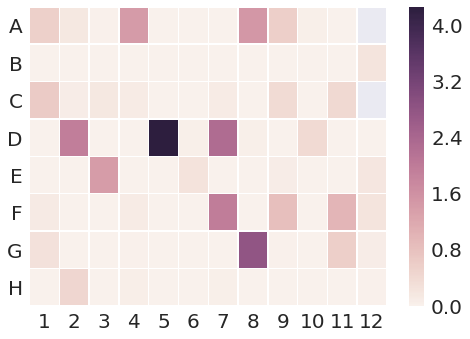

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,A,0.560114,0.168599,0.0258011,1.42393,0,0,0.00171301,1.48017,0.573962,0.0390668,0,NaN
1,B,0,0,0,0,0.00692637,0,0,0,0,0,0,0.232271
2,C,0.63246,0.0935795,0.179553,0.109932,0,0.00655986,0.10442,0,0.379248,0,0.409714,NaN
3,D,0.00851165,1.95763,0,0.00709053,4.25425,0.0349976,2.29418,0.0380041,0.0098955,0.392873,0.00520787,0.0042796
4,E,0.00399113,0,1.409,0,0,0.239535,0.00492376,0,0.0740931,0,0,0.190663
5,F,0.126542,0,0,0.110989,0,0,1.96809,0,0.824353,0,0.995414,0.218181
6,G,0.277572,0,0,0.0249569,0.0075338,0,0,2.80416,0.0245599,0,0.585876,0.098611
7,H,0,0.449204,0,0.0530266,0.00738273,0,0.0422472,0,0,0,0.00430352,0.0198488


In [18]:
minimetaWells(subset1,'ON','YES')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


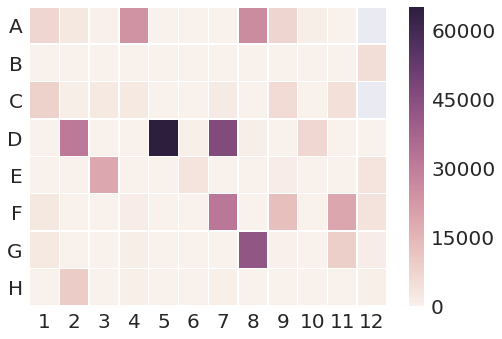

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,A,7007,2539,448,23886,0,0,56,26108,7316,859,0,NaN
1,B,0,0,0,0,157,0,0,0,0,0,0,4992
2,C,8156,932,2190,2079,0,107,1784,0,5835,0,4355,NaN
3,D,179,31074,0,94,65006,736,46101,882,215,6825,118,90
4,E,45,0,18676,0,0,3475,124,0,1156,0,0,3346
5,F,2366,0,0,1513,0,0,31673,0,12452,0,18949,3664
6,G,2177,0,0,780,151,0,0,42201,346,0,8739,1249
7,H,0,9488,0,731,230,0,599,0,0,0,91,646


In [21]:
minimetaWells(subset1,'ON','ABS')

In [11]:
def plotoverlap(df,a,b,plot):
    # a, b are the cluster numbers 
    subset0 = mm[mm['DBclusternum']==a]; subset1 = mm[mm['DBclusternum']==b]

    chip = minimetaWells(subset0,'no','ABS')
    c = chip.iloc[:,1:]
    c = c[c.columns].astype(float)
    ab = np.max(c)
    ab = np.max(ab)
    d = np.where(c > 5000, 1,0);
    #d = np.where(c > 0.3*ab, 1,0);
    rows = ['A','B','C','D','E','F','G','H']
    

    
    chip = minimetaWells(subset1,'no','ABS')
    c = chip.iloc[:,1:]
    c = c[c.columns].astype(float)
    ab = np.max(c)
    ab = np.max(ab)
    e = np.where(c > 5000, 1,0);
    g = np.where(c > 0.3*ab, 1,0);
    
    combined = d+e
    sumone = sum(sum(d))
    sumother = sum(sum(e))
    sumoverlap = sum(combined[combined>1])/2
    
    if plot == "ON":
        f = plt.figure()
        plt.subplot(221)
        sns.heatmap(d,linewidths=.5,yticklabels=rows)

        plt.subplot(222)
        sns.heatmap(e,linewidths=.5,yticklabels=rows)

        plt.subplot(223)
        sns.heatmap(combined,linewidths=.5,yticklabels=rows)

        plt.subplot(224)
        plt.bar([1, 2],[sumoverlap/sumone, sumoverlap/sumother])
        plt.ylim([0,1])
        f.set_figheight(13)
        f.set_figwidth(18)
        plt.show()
    return(sumone)

def overlapmatrix(mm):
    
    numclust = max(mm['DBclusternum'])
    overlapmat = pd.DataFrame(columns=list(range(0,numclust+1)))
    overlapmat[0] = list(range(0,numclust+1))
    print(overlapmat)
    for i in range(0,numclust):
        for j in range(0,numclust):
            num = plotoverlap(mm,i,j,'off')
            overlapmat.iloc[i,j] = num
    
    #sns.heatmap(overlapmat,linewidths=.5)
    #plt.show()
    return(overlapmat)

In [187]:
#clusteroverlap = overlapmatrix(mm)

In [13]:
clusters = mm.groupby('DBclusternum')[["A01", "B02", "C03"]].sum()

In [14]:
mm.iloc[:,24]*mm['Sequence Length']

4016    10522
4017      561
4018     2653
4019     4176
4020      565
4021     2418
4022     2397
4023     2207
4024     1224
4025     1372
4026     1299
4027      428
4028      248
4029     5800
4030     3070
4031        0
4032      771
4033      784
4034     4201
4035      932
4036        0
4037        0
4038      911
4039       59
4040     1001
4041        0
4042        0
4043     3032
4044        0
4045        0
        ...  
5980        0
5981        0
5982        0
5983        0
5984        0
5985        0
5986        0
5987        0
5988        0
5989        0
5990        0
5991        0
5992        0
5993        0
5994        0
5995        0
5996        0
5997        0
5998      230
5999        0
6000        0
6001        0
6002        0
6003        0
6004       40
6005        0
6006        0
6007        0
6008        0
6009        0
dtype: object

In [363]:
# minimeta 
abscov = pd.DataFrame(columns=["DBclusternum"])
abscov.DBclusternum = mm.DBclusternum
abscov_temp = mm.iloc[:,24:].multiply(mm["Sequence Length"], axis="index")
abscov = abscov.join(abscov_temp)

In [306]:
#megahit
abscov = pd.DataFrame(columns=["DBclusternum"])
abscov.DBclusternum = mh.DBclusternum
abscov_temp = mh.iloc[:,24:].multiply(mh["Sequence Length"], axis="index")
abscov = abscov.join(abscov_temp)

In [266]:
#selection
abscov = pd.DataFrame(columns=["DBclusternum"])
sel = mS[mS['Lineage Phylum'] == 'Calescamantes']
abscov.DBclusternum = sel.DBclusternum
abscov_temp = sel.iloc[:,24:].multiply(sel["Sequence Length"], axis="index")
abscov = abscov.join(abscov_temp)

In [267]:
sel

,Scaffold ID,Scaffold Name,Genome ID,Genome,Gene Count,Sequence Length,GC Content,Read Depth,Lineage Domain,Lineage Phylum,...,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12
3155,3300017562 assembled Ga0186926,13156,metaSPAdes,Hotspring sediment microbial communities from ...,5,7897,0.34,1,Bacteria,Calescamantes,...,0.0953527,0,0,0,0,0,0,0,0,0
3305,3300017562 assembled Ga0186926,13306,metaSPAdes,Hotspring sediment microbial communities from ...,7,7129,0.44,1,Bacteria,Calescamantes,...,0,0,0,0,0,0,0,0,0,0


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


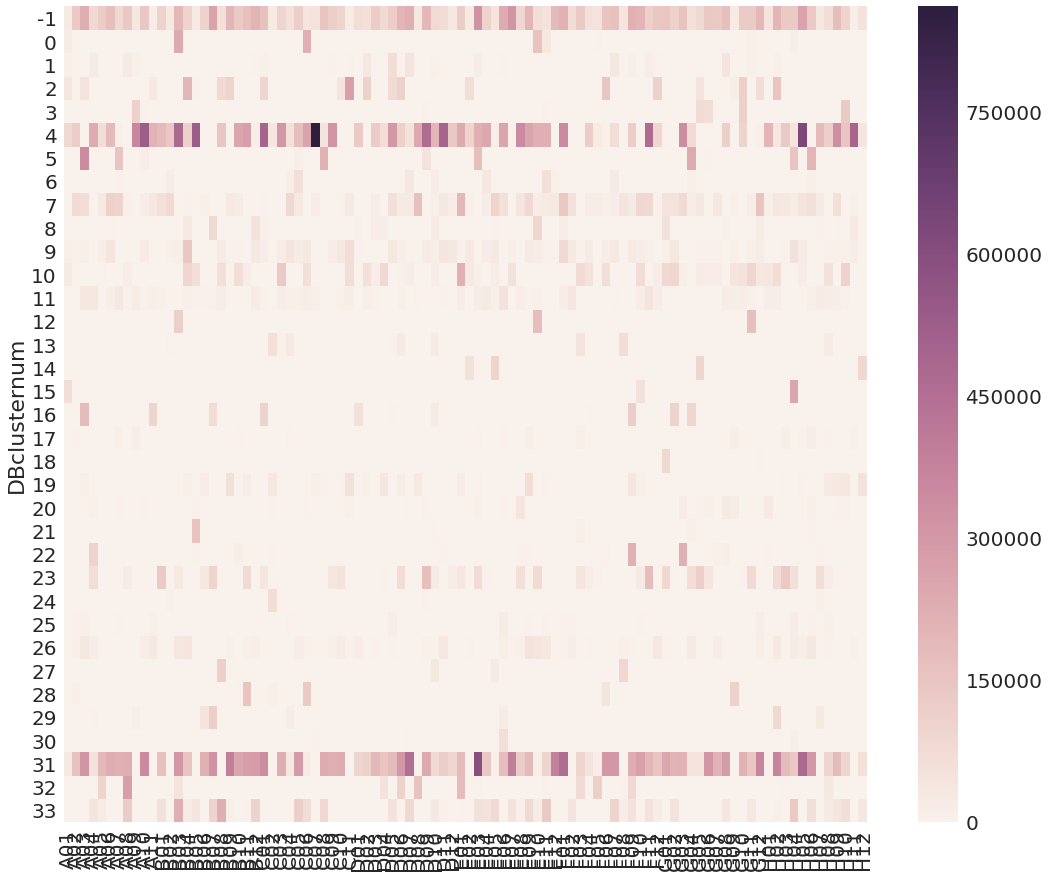

In [364]:
f = plt.figure()
abscov_clust = abscov.groupby("DBclusternum").sum()
sns.heatmap(abscov_clust)
f.set_figheight(15)
f.set_figwidth(18)
plt.show()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


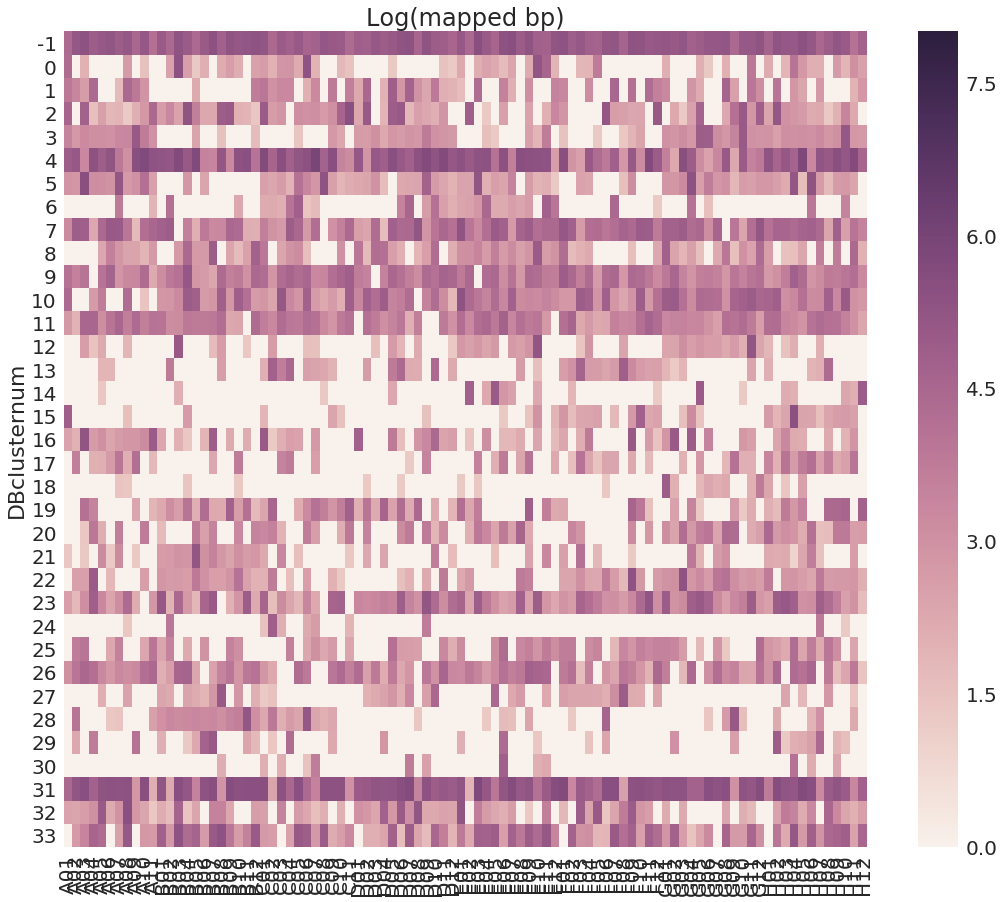

In [365]:
f = plt.figure()
sns.heatmap(np.log10(abscov_clust),vmin=0, vmax=8)
plt.title('Log(mapped bp)')
f.set_figheight(15)
f.set_figwidth(18)
plt.show()

In [342]:
abscov_clust_log_thres.loc[[5]].dropna(axis=1)

,F06,F10
DBclusternum,,
5,2.835691,3.009026


In [300]:
binary.sum()[60:]

F03     8.0
F04     8.0
F05     7.0
F06     9.0
F07     8.0
F08     7.0
F09    11.0
F10     9.0
F11     9.0
F12     9.0
G01     8.0
G02     7.0
G03     7.0
G04    10.0
G05     9.0
G06     7.0
G07     6.0
G08     9.0
G09     9.0
G10     7.0
G11    11.0
G12    11.0
H01     8.0
H02    12.0
H03     8.0
H04    13.0
H05     8.0
H06    10.0
H07     8.0
H08    13.0
H09     9.0
H10     9.0
H11     7.0
H12     6.0
dtype: float64

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


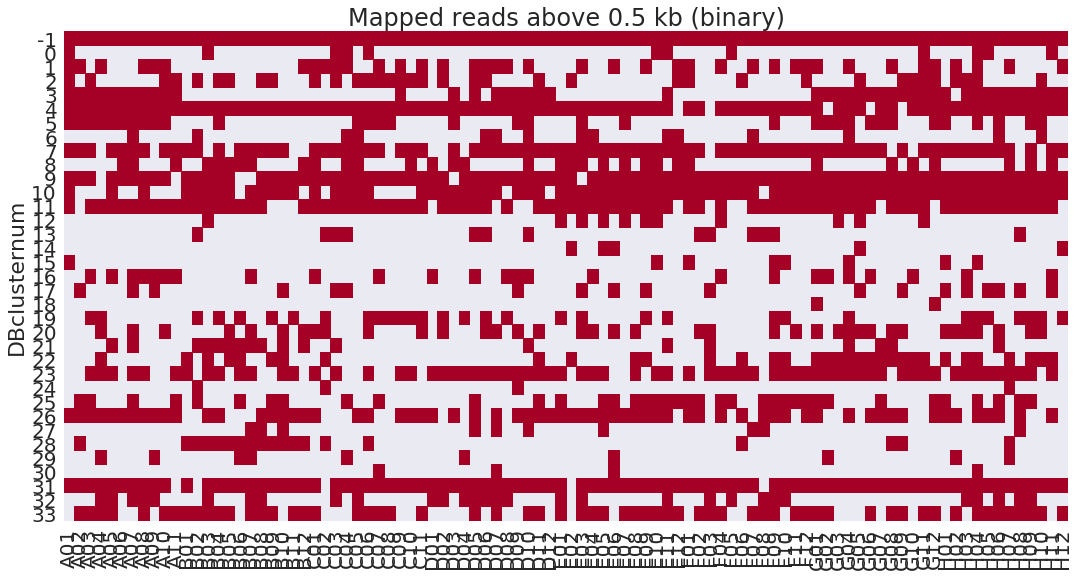

In [372]:
threshold = 500
abscov_clust_log = np.log10(abscov_clust)
abscov_clust_log_thres = abscov_clust_log[abscov_clust_log>np.log10(threshold)]
binary = abscov_clust_log_thres/abscov_clust_log_thres

f = plt.figure()
#sns.heatmap(binary.loc[[5,6,7,11,14,16,17]])#loc[[5,6,7,11,14,16,17]])
sns.heatmap(binary,cbar=False,cmap='RdYlGn')
plt.title('Mapped reads above '+str(threshold/1000)+' kb (binary)')
f.set_figheight(9)
f.set_figwidth(18)
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


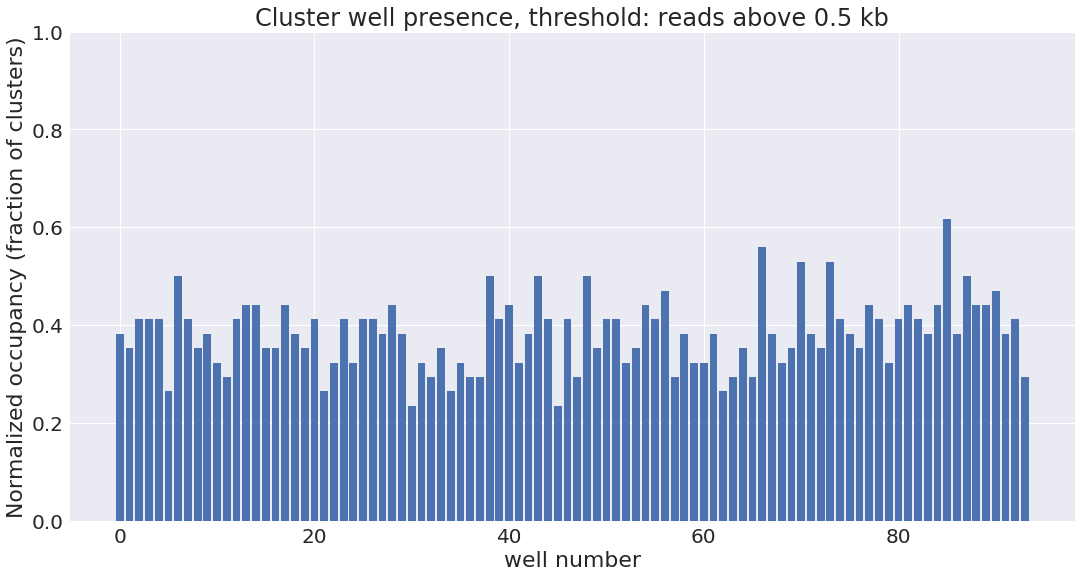

In [374]:
relocc = (binary.sum()-1)/(len(binary)-1)

f = plt.figure()
plt.bar(range(0,len(binary.sum())),relocc)
#plt.subplot(121)
#plt.bar(range(0,len(binary.sum())),abscov_clust.sum())
plt.ylabel('Normalized occupancy (fraction of clusters)')
plt.xlabel('well number')
plt.title('Cluster well presence, threshold: reads above '+str(threshold/1000)+' kb')
#plt.xticks([abscov_clust.T.index])
plt.ylim(0,1)
f.set_figheight(9)
f.set_figwidth(18)
plt.show()


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


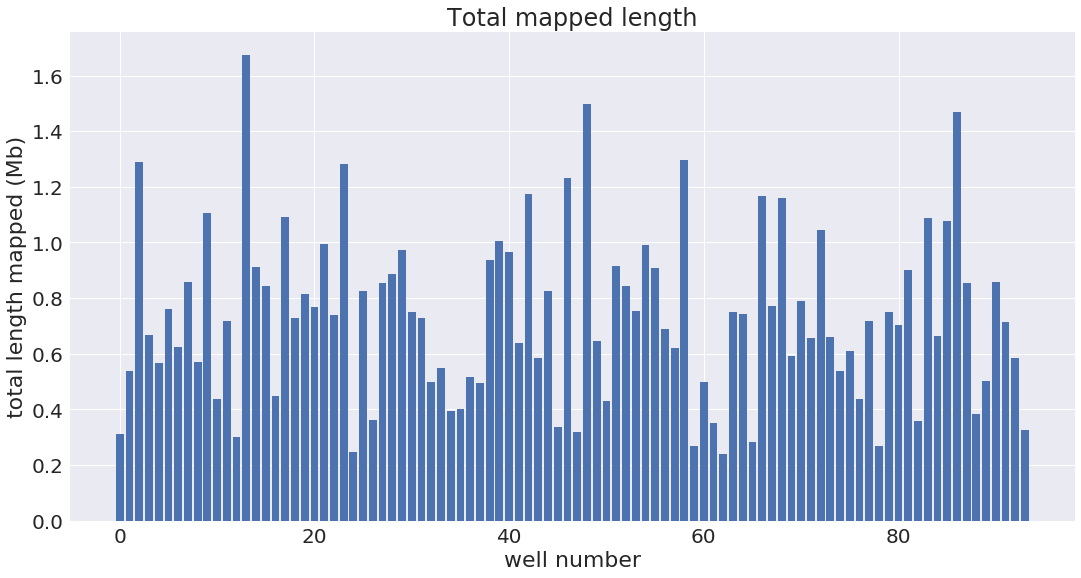

In [369]:
f = plt.figure()
#plt.bar(range(0,len(binary.sum())),binary.sum())
#plt.subplot(121)
plt.bar(range(0,len(binary.sum())),abscov_clust.sum()/1e6)
plt.ylabel('total length mapped (Mb)')
plt.xlabel('well number')
plt.title('Total mapped length')
#plt.xticks([abscov_clust.T.index])
f.set_figheight(9)
f.set_figwidth(18)
plt.show()



In [370]:
asds = abscov_clust_log_thres/abscov_clust_log_thres
asds = asds.fillna(0)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


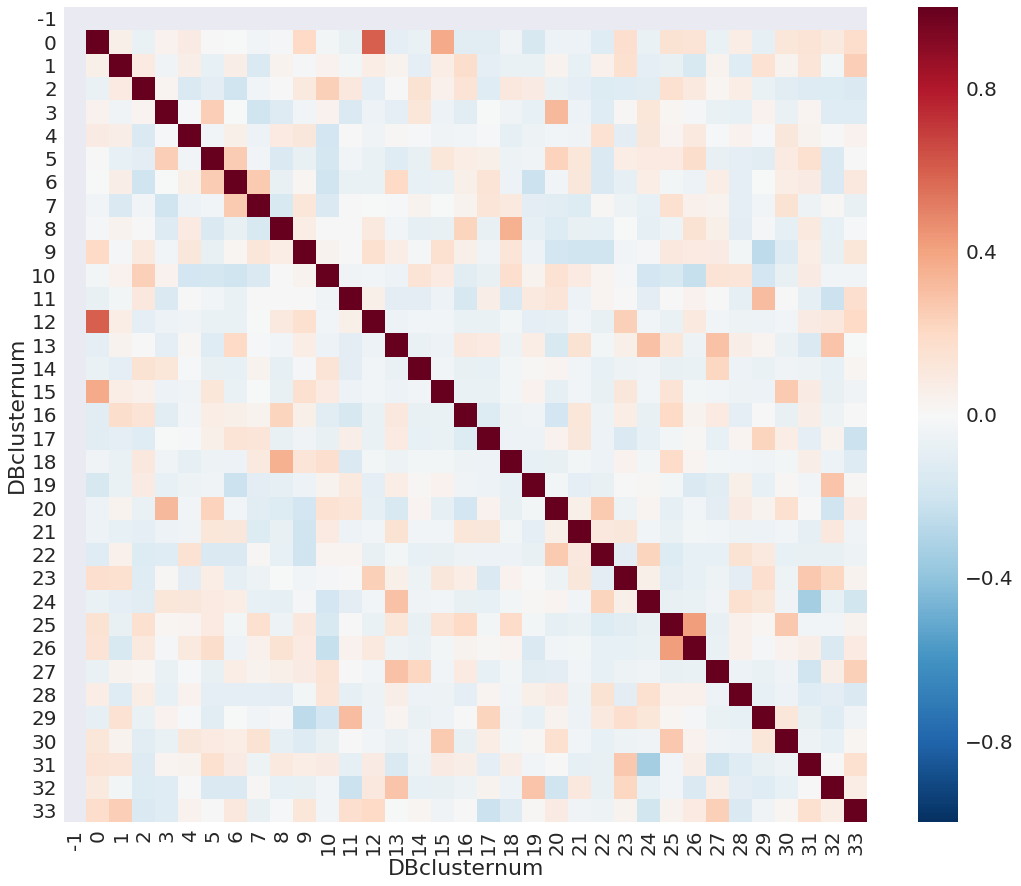

In [371]:
f= plt.figure()
sns.heatmap(asds.T.corr(method="pearson"))
f.set_figheight(15)
f.set_figwidth(18)
plt.show()

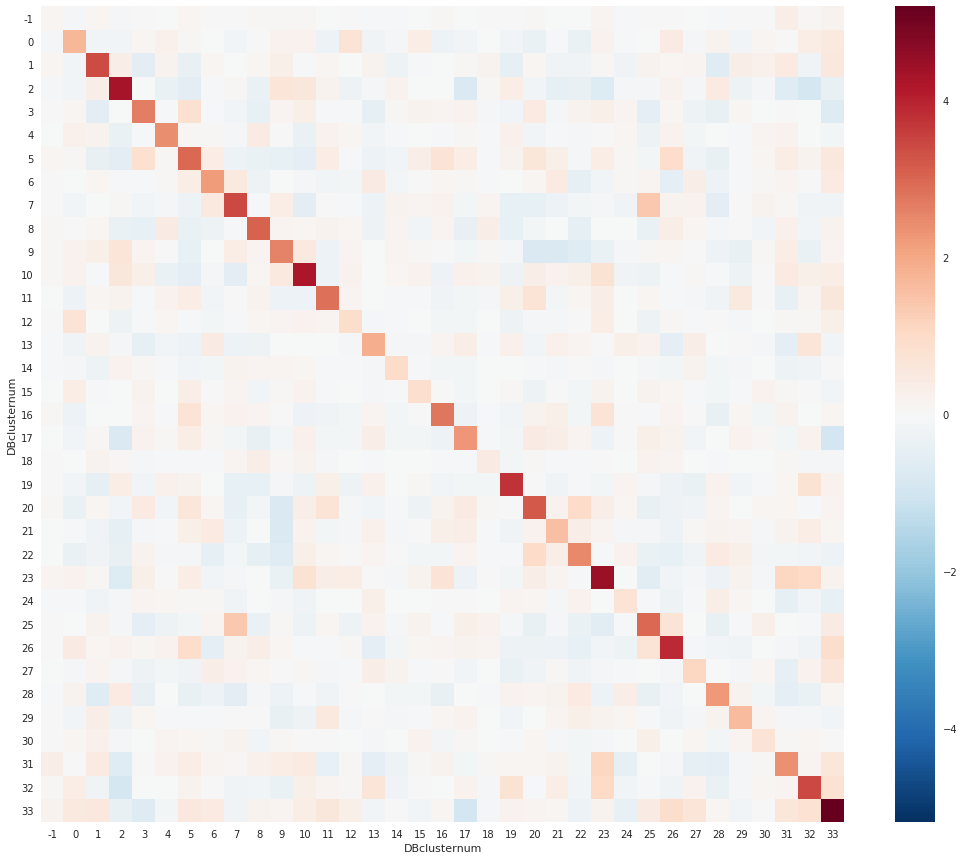

In [21]:
f= plt.figure()
sns.heatmap(abscov_clust_log_thres.fillna(0).T.cov())
f.set_figheight(15)
f.set_figwidth(18)
plt.show()

In [243]:
asds.fillna(0)
abscov_clust_log_thres.loc[[0,1]]


,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12
DBclusternum,,,,,,,,,,,,,,,,,,,,,
0,3.754807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.865554,NaN,5.095274,NaN,3.150449,NaN,NaN,NaN,NaN,NaN,...,3.081707,NaN,3.068557,NaN,3.088136,NaN,NaN,3.457731,NaN,NaN


In [244]:
corrmat = asds.T.corr(method="pearson")

In [245]:
def getpvalfromdf(df):
    pval = np.zeros([df.shape[1],df.shape[1]])
    for i in range(df.shape[1]): # rows are the number of rows in the matrix.
        for j in range(df.shape[1]):
            JonI        = pd.ols(y=df.icol(i), x=df.icol(j), intercept=True)
            pval[i,j]  = JonI.f_stat['p-value']
    return pval

In [246]:
pval = getpvalfromdf(asds.T)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  if __name__ == '__main__':
/usr/lib/python3.6/site-packages/pandas/stats/ols.py:289: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.sm_ols.ssr / self.sm_ols.centered_tss
/usr/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/lib/python3.6/site-packages/pandas/stats/ols.py:187: RuntimeWarning: invalid value encountered in double_scalars
  F = self._r2_raw / (self._r2_raw - self._r2_adj_raw)
/usr/lib/python3.6/site-packages/pandas/stats/ol

In [247]:
pval_df = pd.DataFrame.from_records(pval)
pval_df = pval_df.iloc[1:,1:].reset_index(drop=True)
pval_df.columns = [i for i in range(pval_df.shape[1])]

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


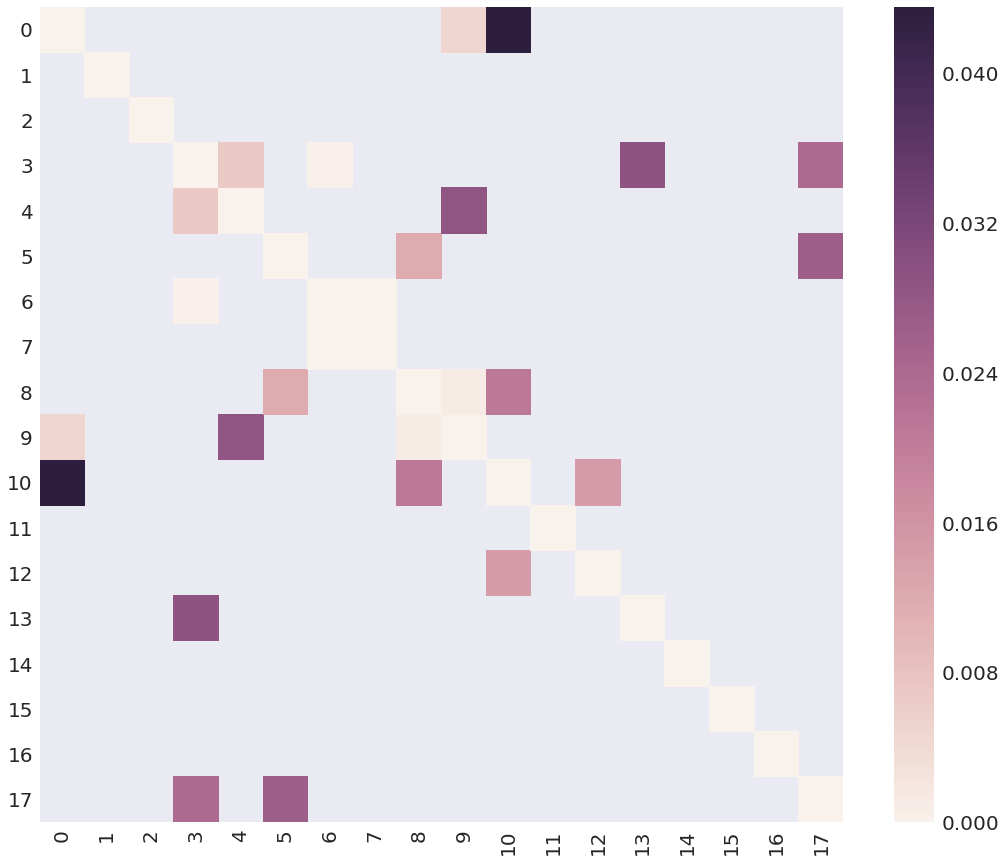

In [248]:
f = plt.figure()
sns.heatmap(pval_df[pval_df<0.05])
f.set_figheight(15)
f.set_figwidth(18)
plt.show()

In [249]:
corrmat_thres = corrmat[corrmat>0.3]
corrmat_thres = corrmat_thres.iloc[1:,1:]
pval_thres = pval_df[pval_df<0.05]

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


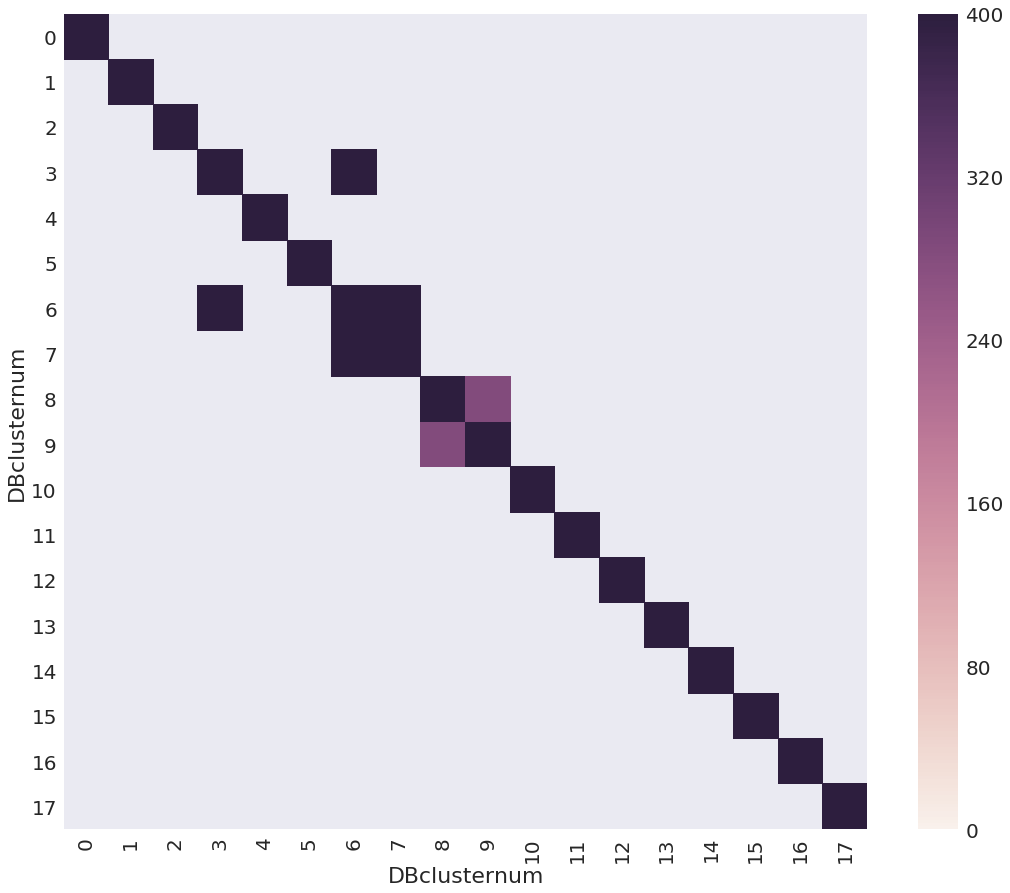

In [250]:

f = plt.figure()
sns.heatmap(corrmat_thres/pval_thres,vmin=0, vmax=400)
f.set_figheight(15)
f.set_figwidth(18)
plt.show()

In [86]:
corrmat_thres/pval_thres

DBclusternum,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
DBclusternum,,,,,,,,,,,,,,,,,,,,,
0,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,inf,NaN,348.288938,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,348.288938,NaN,inf,NaN,NaN,NaN,NaN,...,NaN,NaN,64.933585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN,...,NaN,NaN,NaN,21.046477,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,...,NaN,261.617865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [344]:
#### functional co-occurrence ####

In [362]:
minimetakegg = keggdf_mod[keggdf_mod.contigorigin=='minimetagenomics']
uniqueminimetamod = minimetakegg['D-module'].unique()
uniqueminimetamod[1]

minimetakegg[minimetakegg['D-module']==uniqueminimetamod[1]]

,assembly,contig,K-number,percentage,A,B,C,D-module,D,E-module,E,contigbase,contigorigin,k4_x,k4_y,k5_x,k5_y,DBclusternum
27856,Ga0186926,140173,KO:K10206,84.42,Pathway module,Nucleotide and amino acid metabolism,Lysine metabolism,M00527,"Lysine biosynthesis, DAP aminotransferase path...",K10206,E2.6.1.83; LL-diaminopimelate aminotransferase...,14017,minimetagenomics,25.880568,92.012673,-34.256089,-76.736199,4
30753,Ga0186926,1419810,KO:K10206,73.04,Pathway module,Nucleotide and amino acid metabolism,Lysine metabolism,M00527,"Lysine biosynthesis, DAP aminotransferase path...",K10206,E2.6.1.83; LL-diaminopimelate aminotransferase...,14198,minimetagenomics,-17.226130,90.020358,-45.804871,-49.475988,7
32040,Ga0186926,1438310,KO:K10206,72.92,Pathway module,Nucleotide and amino acid metabolism,Lysine metabolism,M00527,"Lysine biosynthesis, DAP aminotransferase path...",K10206,E2.6.1.83; LL-diaminopimelate aminotransferase...,14383,minimetagenomics,-52.045402,28.182182,7.132788,23.781650,33
38420,Ga0186926,159876,KO:K10206,72.85,Pathway module,Nucleotide and amino acid metabolism,Lysine metabolism,M00527,"Lysine biosynthesis, DAP aminotransferase path...",K10206,E2.6.1.83; LL-diaminopimelate aminotransferase...,15987,minimetagenomics,-53.266837,26.750697,11.375212,19.877689,33


In [348]:
keggdf

,assembly,contig,K-number,percentage,start,end,start2,end2,bitscore,bla,bli
0,Ga0186926,100011,KO:K15012,90.91,1,187,9,195,1.2E-117,382,187
1,Ga0186926,100012,KO:K15011,80.05,4,434,1,431,3.1E-242,763,431
2,Ga0186926,100013,KO:K00344,91.1,1,326,1,326,6.3E-219,685,326
3,Ga0186926,100015,KO:K02483,93.64,1,236,1,233,1.6E-152,487,236
4,Ga0186926,100015,KO:K07666,93.64,1,236,1,233,1.6E-152,487,236
5,Ga0186926,100016,KO:K02484,89.96,1,440,1,448,2.7E-281,875,448
6,Ga0186926,100017,KO:K00019,96.2,1,263,1,263,4.3E-179,565,263
7,Ga0186926,100018,KO:K07001,86.95,19,401,3,383,3.5E-251,785,383
8,Ga0186926,100019,KO:K04761,89.78,1,313,1,313,5.3E-206,647,313
9,Ga0186926,100021,KO:K00338,94.63,1,149,1,149,6.3E-111,359,149


In [345]:
bla = keggdf_mod.groupby("D-module").indices
#len(bla.contigbase)
keggdf_mod.loc[bla['M00005']]

,assembly,contig,K-number,percentage,A,B,C,D-module,D,E-module,E,contigbase,contigorigin,k4_x,k4_y,k5_x,k5_y,DBclusternum
4986,Ga0186926,1069010,KO:K00948,90.91,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",10690,megahit,36.230325,100.785430,-42.068123,-79.890435,8
5040,Ga0186926,106996,KO:K00948,70.78,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",10699,megahit,-12.901535,-68.622085,-64.408387,38.449444,4
6717,Ga0186926,109565,KO:K00948,93.29,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",10956,megahit,67.743541,-9.887274,27.466371,-60.867392,13
7033,Ga0186926,110153,KO:K00948,60.58,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",11015,megahit,-52.596578,34.232029,8.329514,13.946248,-1
7871,Ga0186926,111319,KO:K00948,65.36,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",11131,megahit,43.459003,-65.414531,-87.457725,-25.548138,1
8059,Ga0186926,111628,KO:K00948,99.65,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",11162,megahit,-35.504474,-98.868856,78.921720,25.227965,7
8787,Ga0186926,112738,KO:K00948,43.81,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",11273,megahit,14.668553,-17.130541,48.285607,-15.140718,15
9326,Ga0186926,1135612,KO:K00948,86.81,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",11356,megahit,-67.269034,-80.680822,94.060490,0.586813,6
9551,Ga0186926,114003,KO:K00948,100,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",11400,megahit,4.479000,14.646989,10.179968,-14.254125,16
10185,Ga0186926,115204,KO:K00948,97.11,Pathway module,Carbohydrate and lipid metabolism,Central carbohydrate metabolism,M00005,"PRPP biosynthesis, ribose 5P => PRPP [PATH:map...",K00948,"PRPS, prsA; ribose-phosphate pyrophosphokinase...",11520,megahit,11.289421,91.182677,-17.015515,-84.250825,9


In [346]:
keggdf_mod['D-module'].unique()

array(['M00523', '', 'M00453', 'M00088', 'M00144', 'M00377', 'M00024',
       'M00360', 'M00001', 'M00173', 'M00375', 'M00019', 'M00122',
       'M00095', 'M00793', 'M00400', 'M00632', 'M00048', 'M00034',
       'M00728', 'M00021', 'M00165', 'M00114', 'M00159', 'M00183',
       'M00178', 'M00135', 'M00555', 'M00222', 'M00565', 'M00131',
       'M00157', 'M00331', 'M00017', 'M00288', 'M00018', 'M00116',
       'M00184', 'M00179', 'M00836', 'M00115', 'M00133', 'M00121',
       'M00049', 'M00063', 'M00060', 'M00445', 'M00729', 'M00432',
       'M00335', 'M00083', 'M00595', 'M00255', 'M00392', 'M00373',
       'M00168', 'M00549', 'M00727', 'M00120', 'M00741', 'M00151',
       'M00669', 'M00033', 'M00211', 'M00004', 'M00207', 'M00290',
       'M00569', 'M00548', 'M00545', 'M00038', 'M00250', 'M00080',
       'M00570', 'M00362', 'M00028', 'M00015', 'M00093', 'M00096',
       'M00376', 'M00236', 'M00188', 'M00628', 'M00016', 'M00051',
       'M00029', 'M00031', 'M00194', 'M00239', 'M00155', '